In [1]:
# 1. Import library
import os
import pandas as pd
import tweepy
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from getpass import getpass

print("Imports OK")

Imports OK


In [2]:
# 2. Input credentials (recommended: getpass)
consumer_key = getpass("CONSUMER_KEY: ")
consumer_secret = getpass("CONSUMER_SECRET: ")
access_token = getpass("ACCESS_TOKEN: ")
access_token_secret = getpass("ACCESS_TOKEN_SECRET: ")
bearer_token = getpass("BEARER_TOKEN: ")
# option: store in runtime env for convenience
os.environ["CONSUMER_KEY"] = consumer_key
os.environ["CONSUMER_SECRET"] = consumer_secret
os.environ["ACCESS_TOKEN"] = access_token
os.environ["ACCESS_TOKEN_SECRET"] = access_token_secret
os.environ["BEARER_TOKEN"] = bearer_token
print("Credentials loaded to runtime (not saved to disk).")

CONSUMER_KEY: ··········
CONSUMER_SECRET: ··········
ACCESS_TOKEN: ··········
ACCESS_TOKEN_SECRET: ··········
BEARER_TOKEN: ··········
Credentials loaded to runtime (not saved to disk).


In [3]:
# 3. OAuth1 (v1.1)
consumer_key = os.environ.get("CONSUMER_KEY")
consumer_secret = os.environ.get("CONSUMER_SECRET")
access_token = os.environ.get("ACCESS_TOKEN")
access_token_secret = os.environ.get("ACCESS_TOKEN_SECRET")

try:
    auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
    api = tweepy.API(auth)
    api.verify_credentials()
    print("OAuth1 auth OK")
except Exception as e:
    print("OAuth1 error:", e)

OAuth1 auth OK


In [4]:
# 4. Initialize Client v2 (Bearer)
bearer_token = os.environ.get("BEARER_TOKEN")
try:
    client = tweepy.Client(bearer_token=bearer_token)
    print("Client v2 initialized")
except Exception as e:
    print("Client init error:", e)

Client v2 initialized


In [5]:
# 5. Search tweets
query = '(#Whoosh OR #KCIC OR #KeretaCepat OR "Whoosh" OR "KCIC" OR "kereta cepat") lang:id -is:retweet'
try:
    response = client.search_recent_tweets(query=query, max_results=100, tweet_fields=["created_at","author_id","public_metrics"])
    tweets = response.data if getattr(response,"data",None) else []
    print("Found tweets:", len(tweets))
except Exception as e:
    print("Search error:", e); tweets = []

Found tweets: 100


In [14]:
# 6. Convert to DataFrame
import pandas as pd
data = []
for t in tweets:
    pm = t.public_metrics if getattr(t,"public_metrics",None) else {}
    data.append({
        "date": getattr(t,"created_at",None),
        "author_id": getattr(t,"author_id",None),
        "text": getattr(t,"text",""),
        "likes": pm.get("like_count",0),
        "retweets": pm.get("retweet_count",0),
        "replies": pm.get("reply_count",0)
    })
df = pd.DataFrame(data)
df

,date,author_id,text,likes,retweets,replies
0,2025-11-17 14:07:36+00:00,1859723872070979584,KPK Ungkap Modus Jual Beli Tanah Negara di Pro...,0,0,0
1,2025-11-17 14:06:11+00:00,1688328064357564417,Dirut KCIC soal Utang Whoosh: Kita Serahkan ke...,0,0,0
2,2025-11-17 14:02:26+00:00,1454008204027854853,Pejabat Negara Jual Tanah Negara Enak Tenan ...,1,1,0
3,2025-11-17 13:56:39+00:00,38915157,Restrukturisasi Utang Kereta Cepat Whoosh Dise...,0,0,0
4,2025-11-17 13:54:34+00:00,1466815910518263808,Restrukturisasi Utang Kereta Cepat Whoosh: KCI...,0,0,0
...,...,...,...,...,...,...
95,2025-11-17 08:13:54+00:00,1327592034815811584,@AgusSud22579681 Ya berarti fix jokowi itu idi...,0,0,0
96,2025-11-17 08:09:25+00:00,1245999940637044736,"@BrownisMatcha_ cukup tapi jgn naik whoosh PP,...",0,0,0
97,2025-11-17 08:05:01+00:00,103551225,"Mantan Menteri Koordinator Bidang Politik, Huk...",0,0,0
98,2025-11-17 08:03:31+00:00,1475097258278354946,@casajoye iyaa plss mahal bgt buat bayar utang...,0,0,0


In [7]:
# 7. Load sentiment model (optional)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()
print("Model loaded on", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Model loaded on cpu


In [8]:
# 8. Sentiment function
label_map = {0:"negative",1:"neutral",2:"positive"}
def detect_sentiment(text):
    if not isinstance(text,str) or text.strip()=="":
        return "neutral", 0.0
    enc = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
    prob = F.softmax(logits, dim=1)[0].cpu().numpy()
    idx = int(prob.argmax())
    return label_map[idx], float(prob[idx])

In [15]:
# 9. Apply sentiment (optional)
sentiments = []
confs = []
for txt in df["text"]:
    s,c = detect_sentiment(txt)
    sentiments.append(s)
    confs.append(c)
df["sentiment"] = sentiments
df["confidence"] = confs
df


,date,author_id,text,likes,retweets,replies,sentiment,confidence
0,2025-11-17 14:07:36+00:00,1859723872070979584,KPK Ungkap Modus Jual Beli Tanah Negara di Pro...,0,0,0,neutral,0.851612
1,2025-11-17 14:06:11+00:00,1688328064357564417,Dirut KCIC soal Utang Whoosh: Kita Serahkan ke...,0,0,0,neutral,0.789465
2,2025-11-17 14:02:26+00:00,1454008204027854853,Pejabat Negara Jual Tanah Negara Enak Tenan ...,1,1,0,neutral,0.582551
3,2025-11-17 13:56:39+00:00,38915157,Restrukturisasi Utang Kereta Cepat Whoosh Dise...,0,0,0,neutral,0.826376
4,2025-11-17 13:54:34+00:00,1466815910518263808,Restrukturisasi Utang Kereta Cepat Whoosh: KCI...,0,0,0,neutral,0.795855
...,...,...,...,...,...,...,...,...
95,2025-11-17 08:13:54+00:00,1327592034815811584,@AgusSud22579681 Ya berarti fix jokowi itu idi...,0,0,0,negative,0.651471
96,2025-11-17 08:09:25+00:00,1245999940637044736,"@BrownisMatcha_ cukup tapi jgn naik whoosh PP,...",0,0,0,neutral,0.766862
97,2025-11-17 08:05:01+00:00,103551225,"Mantan Menteri Koordinator Bidang Politik, Huk...",0,0,0,neutral,0.704288
98,2025-11-17 08:03:31+00:00,1475097258278354946,@casajoye iyaa plss mahal bgt buat bayar utang...,0,0,0,negative,0.667657


In [16]:
# Hitung jumlah tiap sentimen
sentiment_counts = df["sentiment"].value_counts()
print("Jumlah setiap sentimen:")
print(sentiment_counts)

# Hitung proporsi tiap sentimen (persentase)
sentiment_proportion = df["sentiment"].value_counts(normalize=True) * 100
print("\nProporsi setiap sentimen (%):")
print(sentiment_proportion.round(2))

Jumlah setiap sentimen:
sentiment
neutral     52
negative    38
positive    10
Name: count, dtype: int64

Proporsi setiap sentimen (%):
sentiment
neutral     52.0
negative    38.0
positive    10.0
Name: proportion, dtype: float64


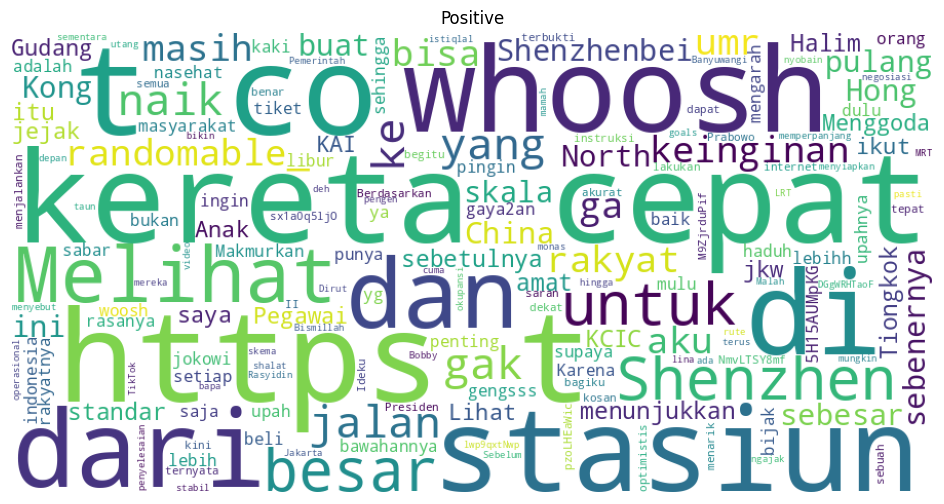

In [10]:
# 10. WordCloud - Positive example
texts_pos = df.loc[df["sentiment"]=="positive","text"].tolist()
if texts_pos:
    wc = WordCloud(width=900, height=450, background_color="white").generate(" ".join(texts_pos))
    plt.figure(figsize=(12,6)); plt.imshow(wc); plt.axis("off"); plt.title("Positive"); plt.show()
else:
    print("No positive tweets")


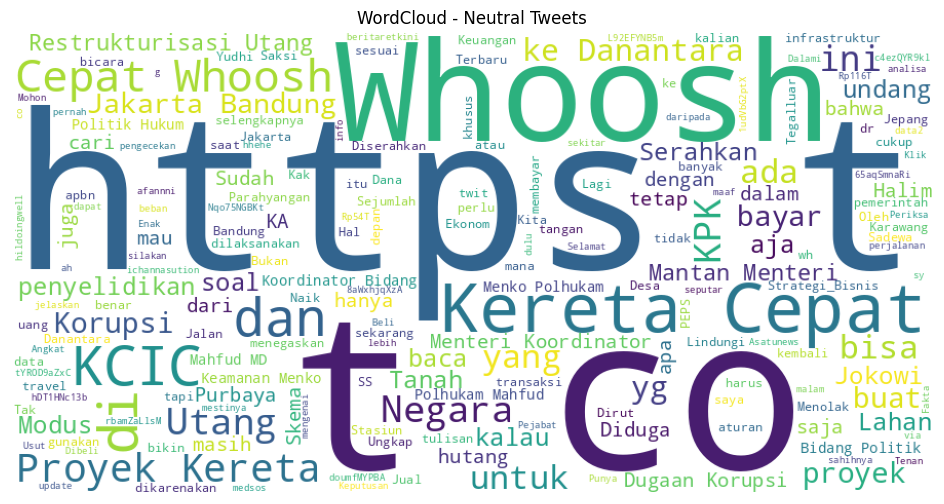

In [12]:
# WordCloud - Neutral
texts_neu = df.loc[df["sentiment"]=="neutral", "text"].tolist()
if texts_neu:
    wc = WordCloud(width=900, height=450, background_color="white").generate(" ".join(texts_neu))
    plt.figure(figsize=(12,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title("WordCloud - Neutral Tweets")
    plt.show()
else:
    print("No neutral tweets")

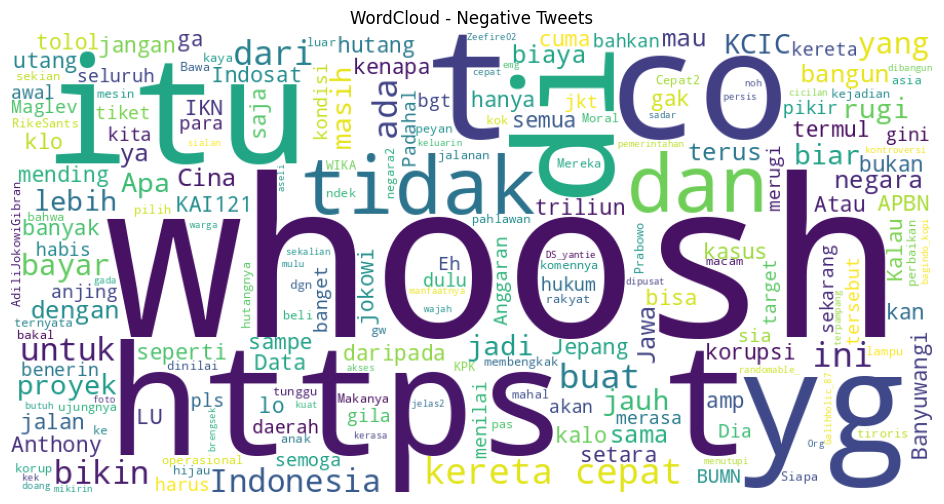

In [13]:
# WordCloud - Negative
texts_neg = df.loc[df["sentiment"]=="negative", "text"].tolist()
if texts_neg:
    wc = WordCloud(width=900, height=450, background_color="white").generate(" ".join(texts_neg))
    plt.figure(figsize=(12,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title("WordCloud - Negative Tweets")
    plt.show()
else:
    print("No negative tweets")

In [17]:
# Save sebagai TXT (TSV format, tab-separated)
output_file = "tweets_with_sentiment.txt"
df.to_csv(output_file, sep="\t", index=False)
print("Saved to:", output_file)

from google.colab import files
files.download(output_file)

Saved to: tweets_with_sentiment.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Save TXT dalam format tabel rapi
txt_output = "tweets_pretty_table.txt"

with open(txt_output, "w", encoding="utf-8") as f:
    f.write(df.to_string())

print("Saved:", txt_output)

from google.colab import files
files.download(txt_output)

Saved: tweets_pretty_table.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>